# Import Libraries

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

from datasets import load_dataset
import numpy as np

c:\Users\szsze\AppData\Local\Programs\Python\Venvs\DeepLearning-3.10.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the Data Set

In [2]:
TOTAL_SIZE = 1000
TRAIN_SIZE = int(0.8 * TOTAL_SIZE)
COLUMNS = ["plans", "walls", "colors", "footprints"]
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 512x512 in size
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [3]:
ds = load_dataset("zimhe/pseudo-floor-plan-12k")
ds = ds["train"]
ds = ds.shuffle(seed=11)

(-0.5, 511.5, 511.5, -0.5)

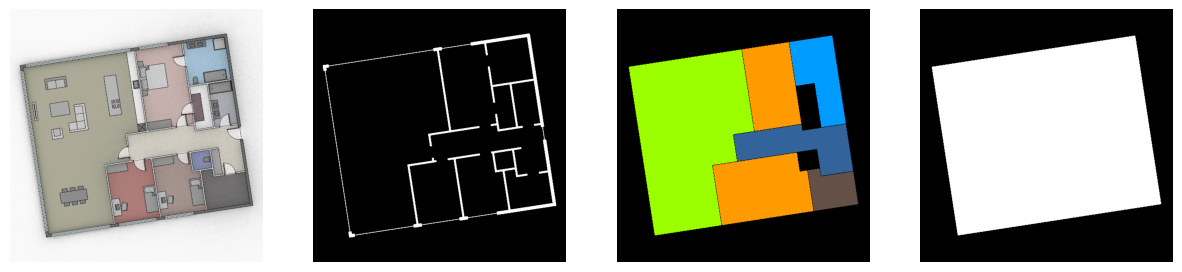

In [4]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 4, 1)
plt.imshow(ds[0]["plans"])
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(ds[0]["walls"])
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(ds[0]["colors"])
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(ds[0]["footprints"])
plt.axis('off')

In [5]:
def cast_images(batch):
    batch["plans"] = tf.cast(batch["plans"], tf.float32)
    batch["walls"] = tf.cast(batch["walls"], tf.float32)
    batch["colors"] = tf.cast(batch["colors"], tf.float32)
    batch["footprints"] = tf.cast(batch["footprints"], tf.float32)
    return batch

In [6]:
def extract_cols(batch):
    return batch[COLUMNS[0]][:,:,:,:-1][0], \
        batch[COLUMNS[1]][0], \
        batch[COLUMNS[2]][0], \
        batch[COLUMNS[3]][0]

In [7]:
def resize(plans, walls, colors, footprints, height, width):
  plans = tf.image.resize(plans, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  walls = tf.image.resize(walls, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  colors = tf.image.resize(colors, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  footprints = tf.image.resize(footprints, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return plans, walls, colors, footprints

In [8]:
def random_crop(plans, walls, colors, footprints):
  stacked_image = tf.stack([plans, walls, colors, footprints], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[4, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1], cropped_image[2], cropped_image[3]

In [9]:
# Normalizing the images to [-1, 1]
def normalize(plans, walls, colors, footprints):
  plans = (plans / 127.5) - 1
  walls = (walls / 127.5) - 1
  colors = (colors / 127.5) - 1
  footprints = (footprints / 127.5) - 1

  return plans, walls, colors, footprints

In [10]:
@tf.function()
def random_jitter(plans, walls, colors, footprints):
  # Resizing to 550x550
  plans, walls, colors, footprints = resize(plans, walls, colors, footprints, 550, 550)

  # Random cropping back to 512x512
  plans, walls, colors, footprints = random_crop(plans, walls, colors, footprints)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    plans = tf.image.flip_left_right(plans)
    walls = tf.image.flip_left_right(walls)
    colors = tf.image.flip_left_right(colors)
    footprints = tf.image.flip_left_right(footprints)

  return plans, walls, colors, footprints

In [11]:
def load_image_train(batch):
  batch = cast_images(batch)
  plans, walls, colors, footprints = extract_cols(batch)
  plans, walls, colors, footprints = random_jitter(plans, walls, colors, footprints)
  plans, walls, colors, footprints = normalize(plans, walls, colors, footprints)
  input = tf.concat([walls, colors, footprints], axis=-1)

  return input, plans

In [12]:
def load_image_test(batch):
  batch = cast_images(batch)
  plans, walls, colors, footprints = extract_cols(batch)
  plans, walls, colors, footprints = resize(plans, walls, colors, footprints,
                                   IMG_HEIGHT, IMG_WIDTH)
  plans, walls, colors, footprints = normalize(plans, walls, colors, footprints)
  input = tf.concat([walls, colors, footprints], axis=-1)

  return input, plans

In [13]:
train_ds = ds.select(range(TRAIN_SIZE))
test_ds = ds.select(range(TRAIN_SIZE, TOTAL_SIZE))

train_dataset = train_ds.to_tf_dataset(
    columns=COLUMNS,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = test_ds.to_tf_dataset(
    columns=COLUMNS,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Build the Generator

In [14]:
OUTPUT_CHANNELS = 3

In [15]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [16]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [17]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 9])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 256, 256, 64)
    downsample(128, 4),  # (batch_size, 128, 128, 128)
    downsample(256, 4),  # (batch_size, 64, 64, 128)
    downsample(512, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(512, 4),  # (batch_size, 32, 32, 1024)
    upsample(256, 4),  # (batch_size, 64, 64, 512)
    upsample(128, 4),  # (batch_size, 128, 128, 256)
    upsample(64, 4),  # (batch_size, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

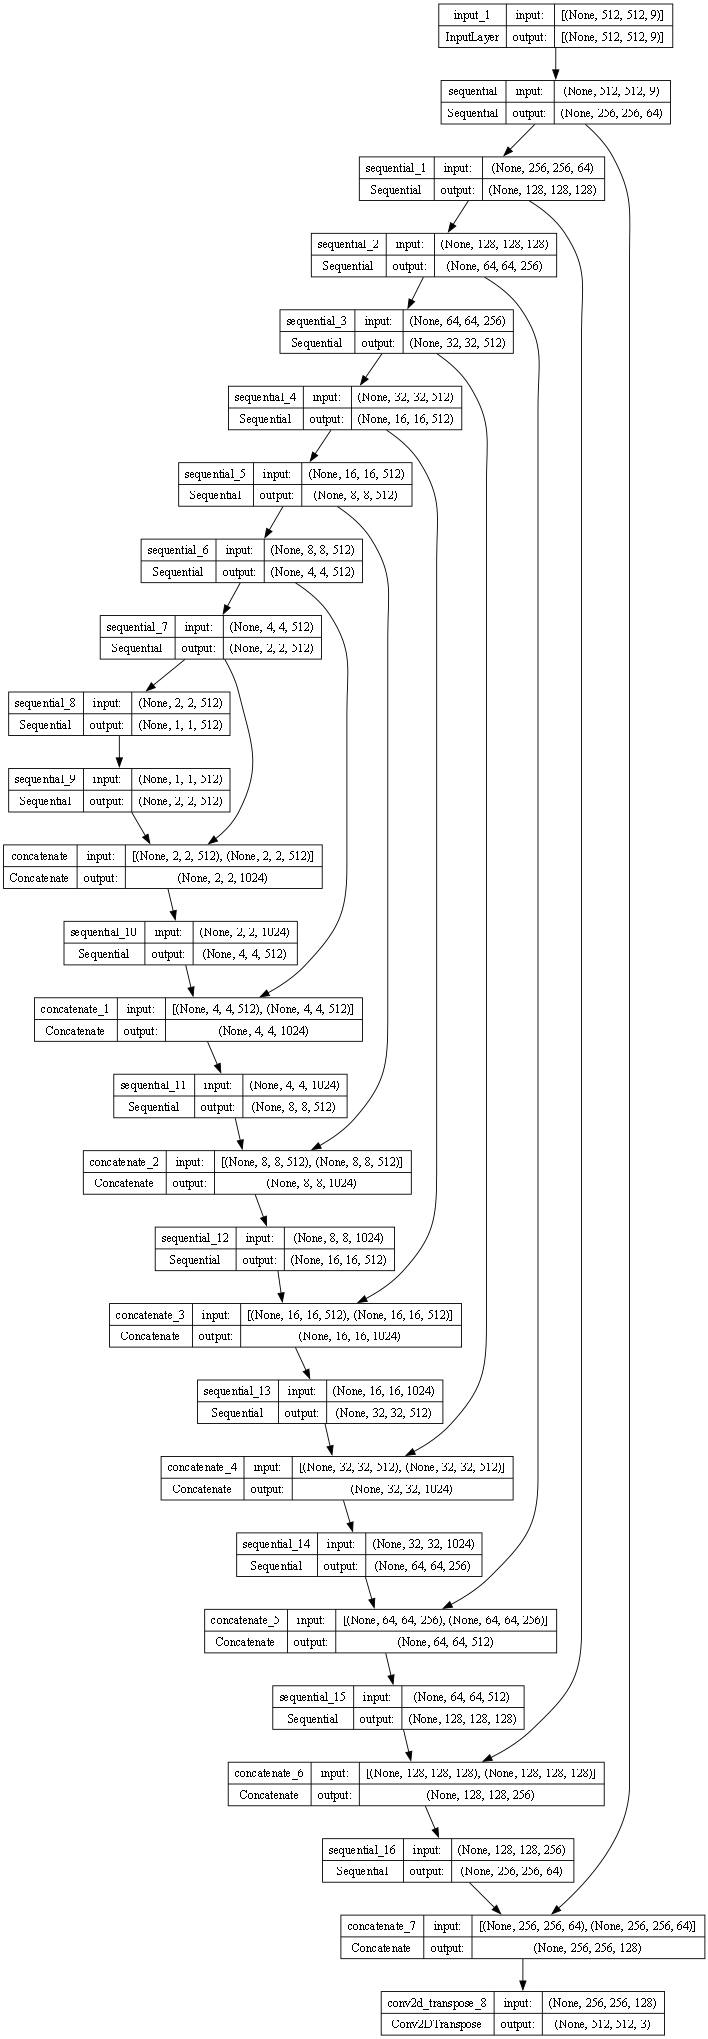

In [18]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

# Define the Generator Loss

In [19]:
LAMBDA = 100

In [20]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

# Build the Discriminator

In [22]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[512, 512, 9], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 512, 512, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 256, 256, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 128, 128, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 64, 64, 128)
  down4 = downsample(256, 4)(down3)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

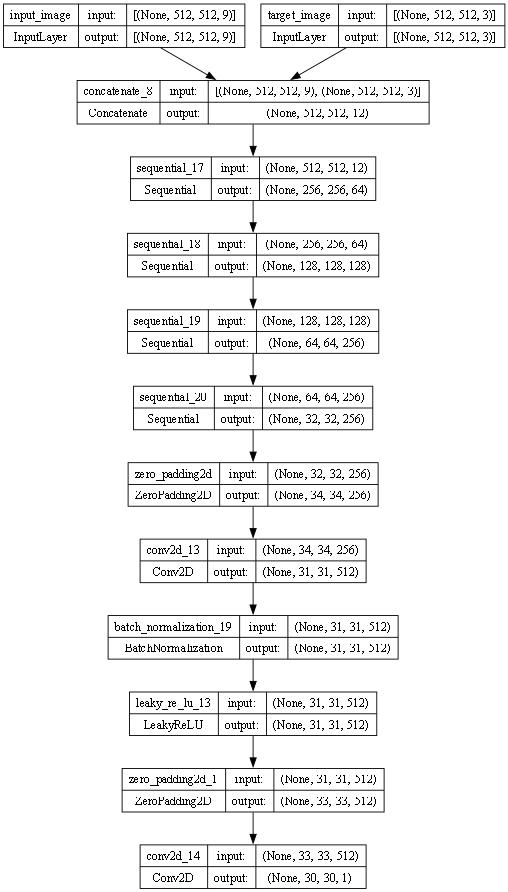

In [23]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

# Define the Discriminator Loss

In [24]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

# Define Optimizers and a checkpoint-server

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Generate Images

In [27]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0][:,:,0:3], test_input[0][:,:,3:6], test_input[0][:,:,6:9], tar[0], prediction[0]]
  title = ['Walls', 'Colors', 'Footprint', 'Ground Truth', 'Predicted Image']

  for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

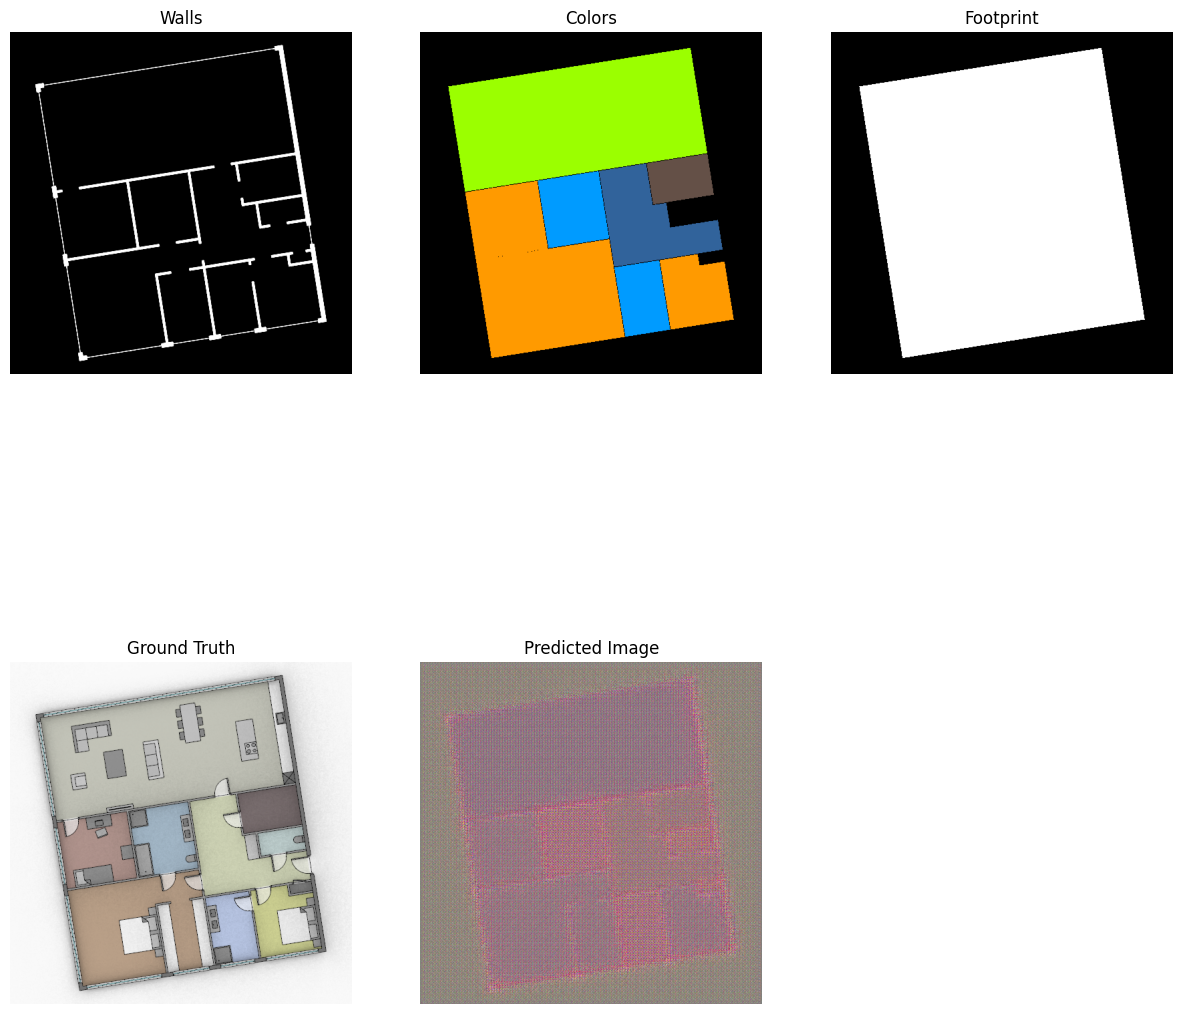

In [28]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

# Training

In [29]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [30]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [31]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    step_val = int(step.numpy()) if isinstance(step, tf.Tensor) else int(step)
    if (step_val) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step_val//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step_val+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step_val + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [37]:
!kill 21172

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 25564), started 0:07:19 ago. (Use '!kill 25564' to kill it.)

Time taken for 1000 steps: 51.71 sec



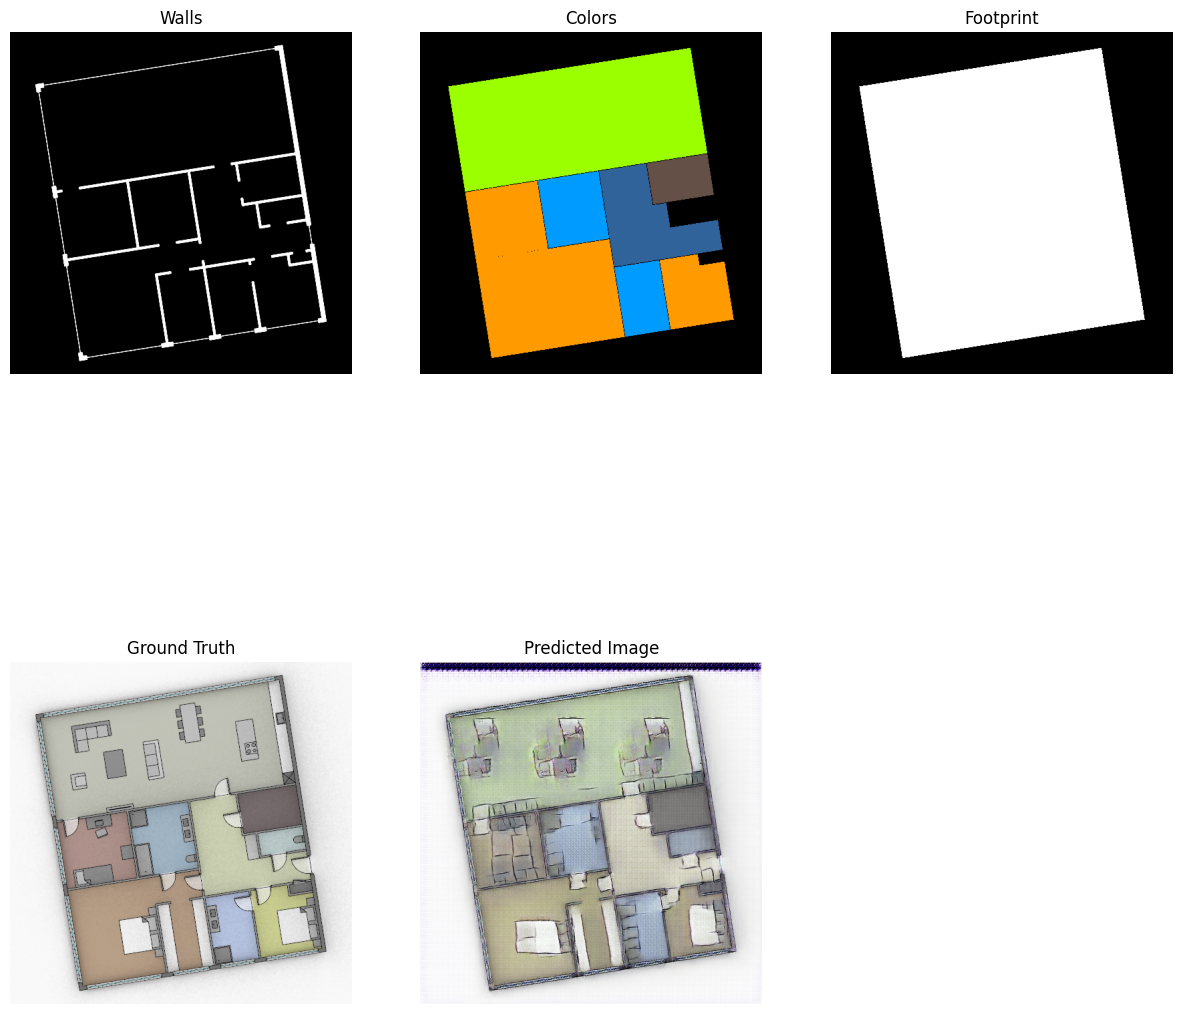

Step: 39k
....................................................................................................

In [33]:
fit(train_dataset, test_dataset, steps=40000)

# Generating Images

In [34]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

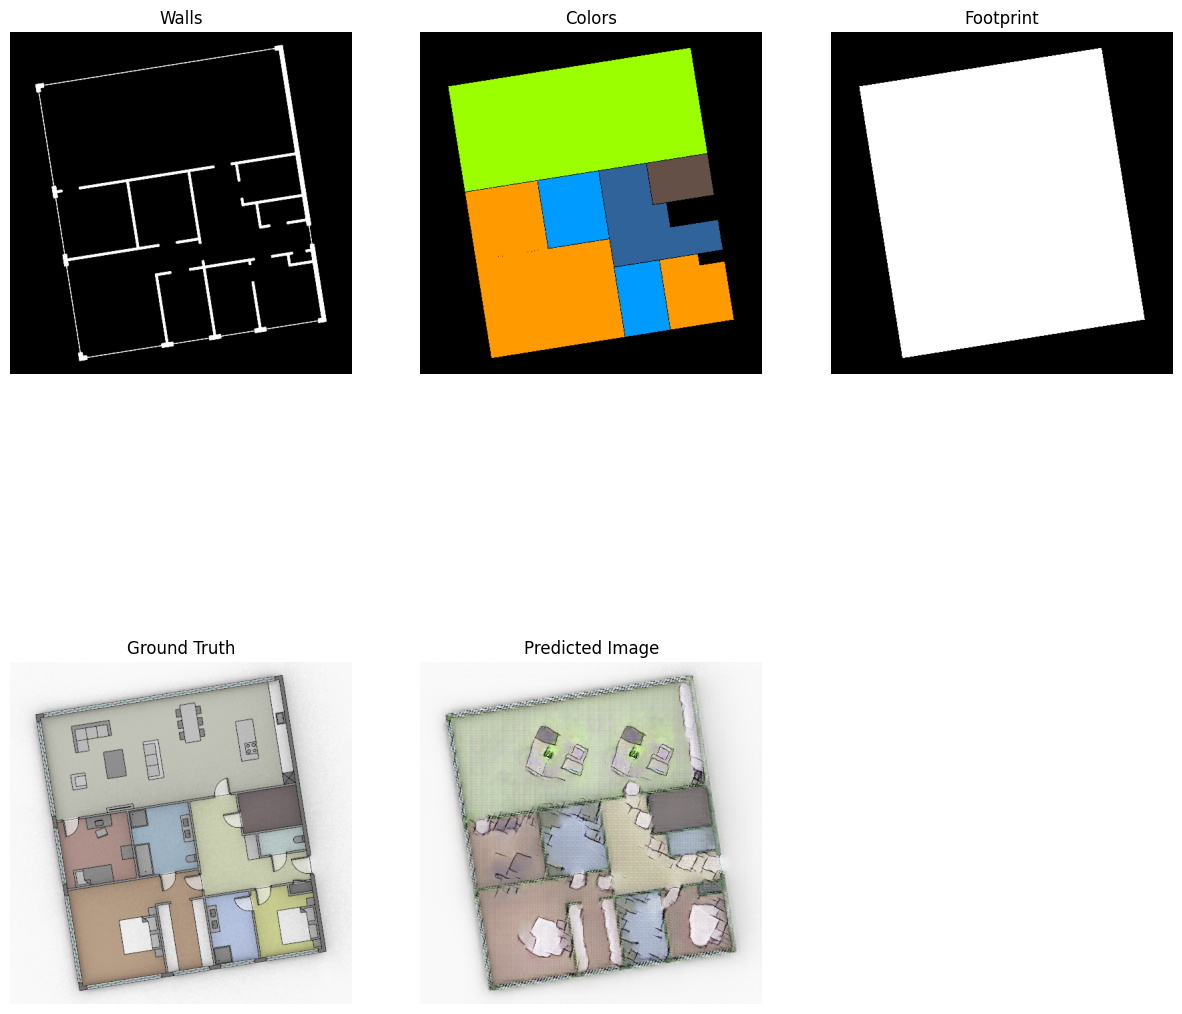

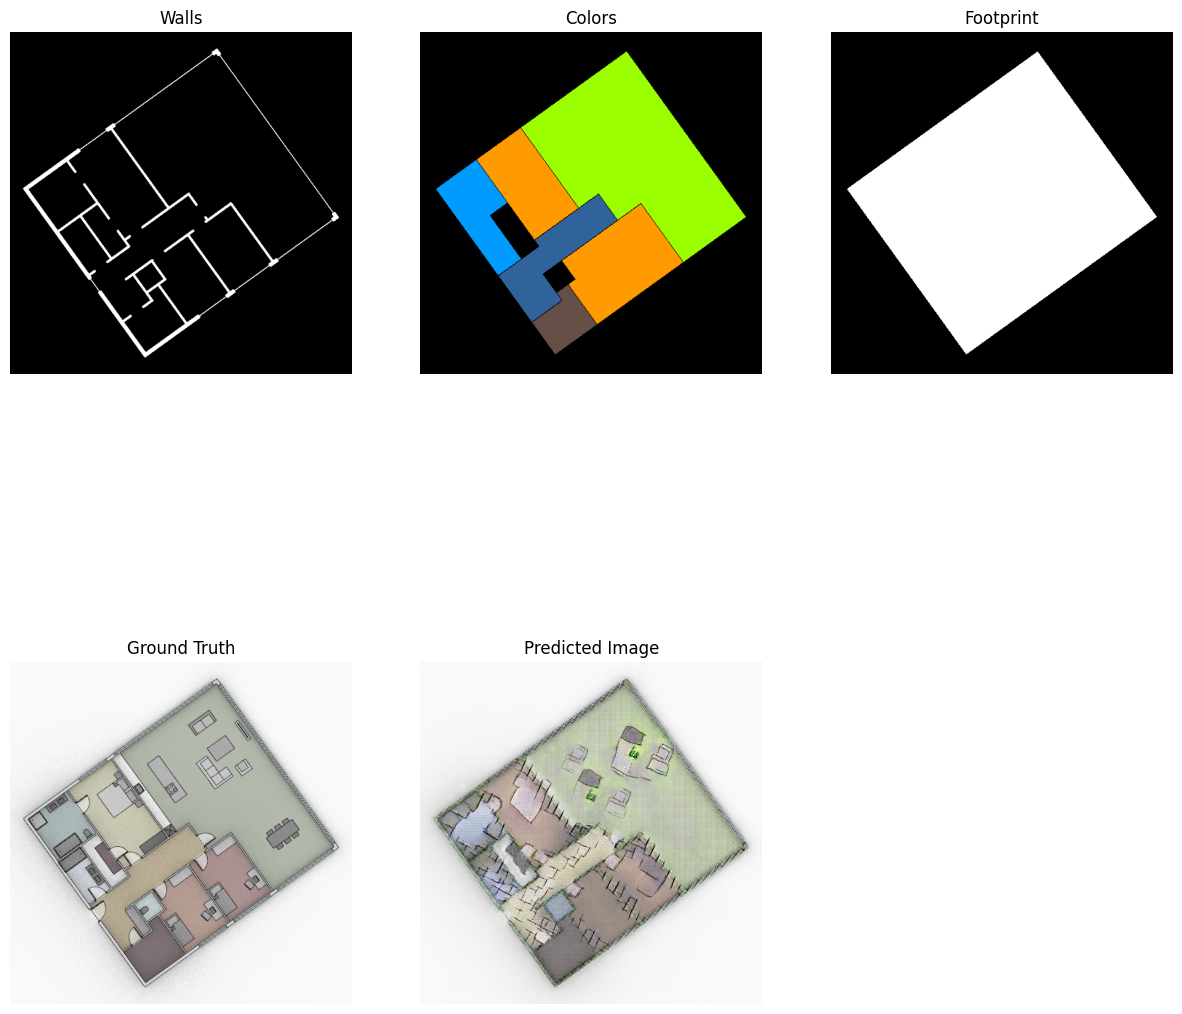

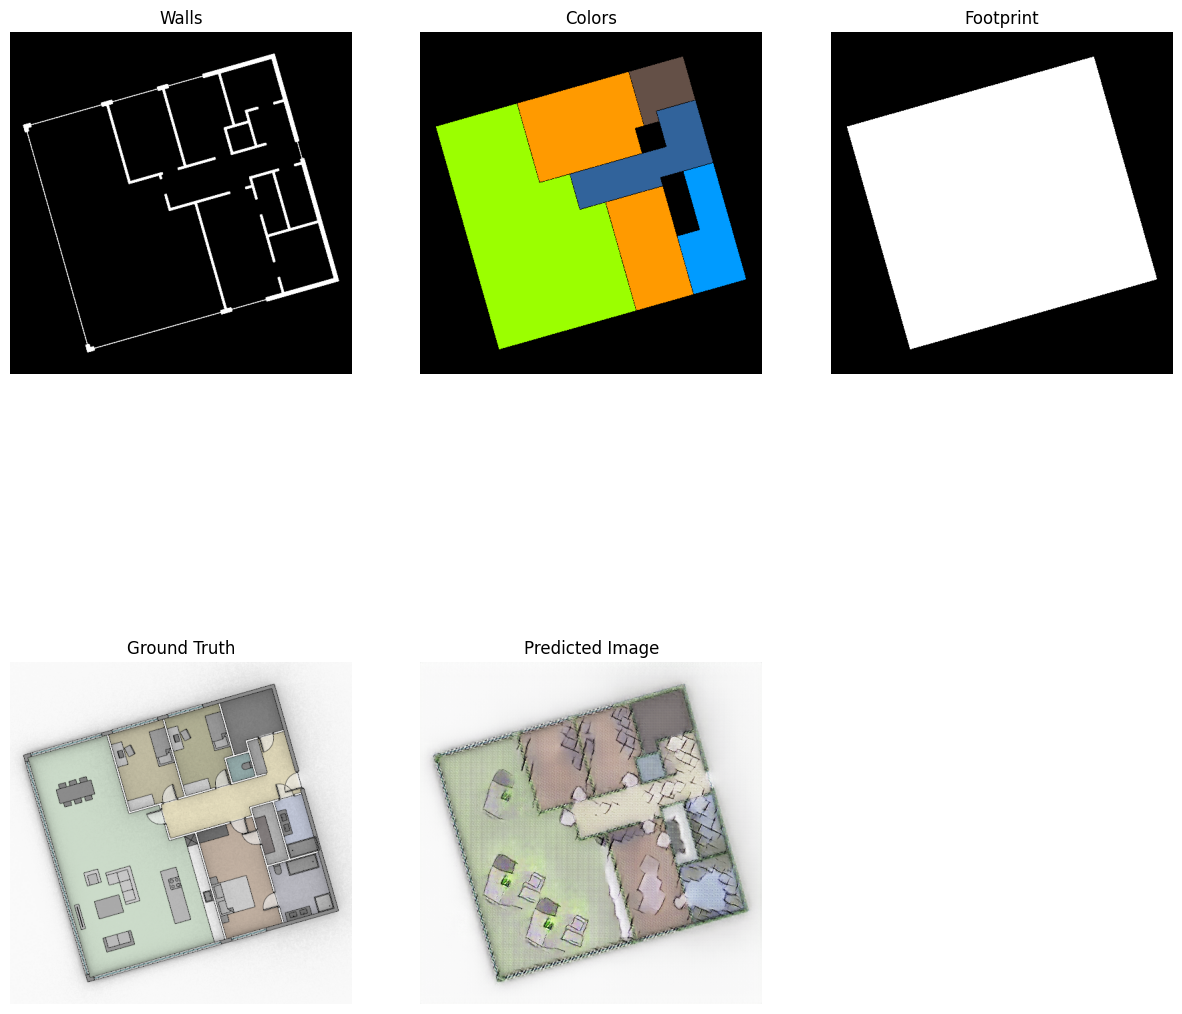

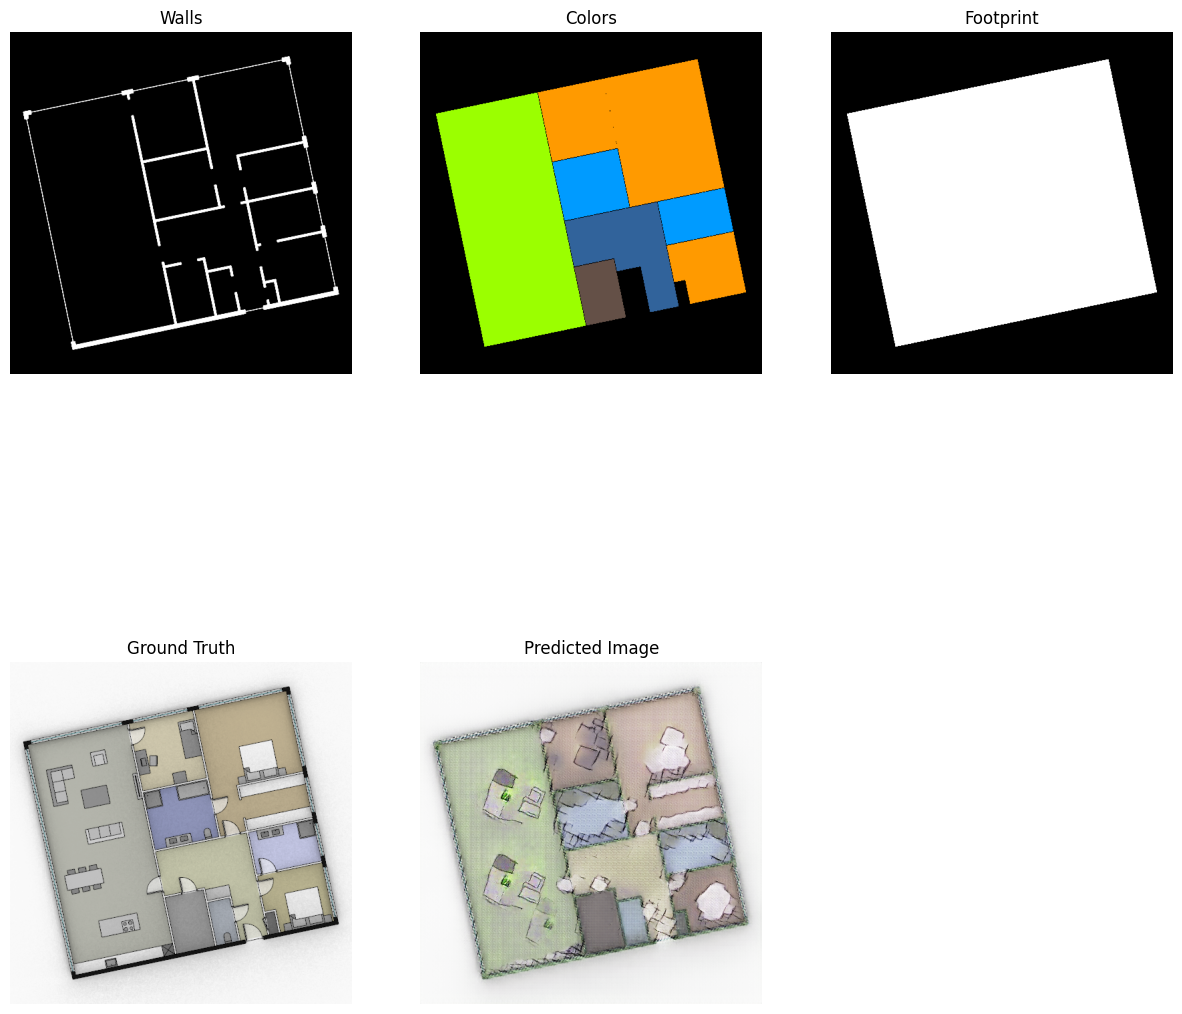

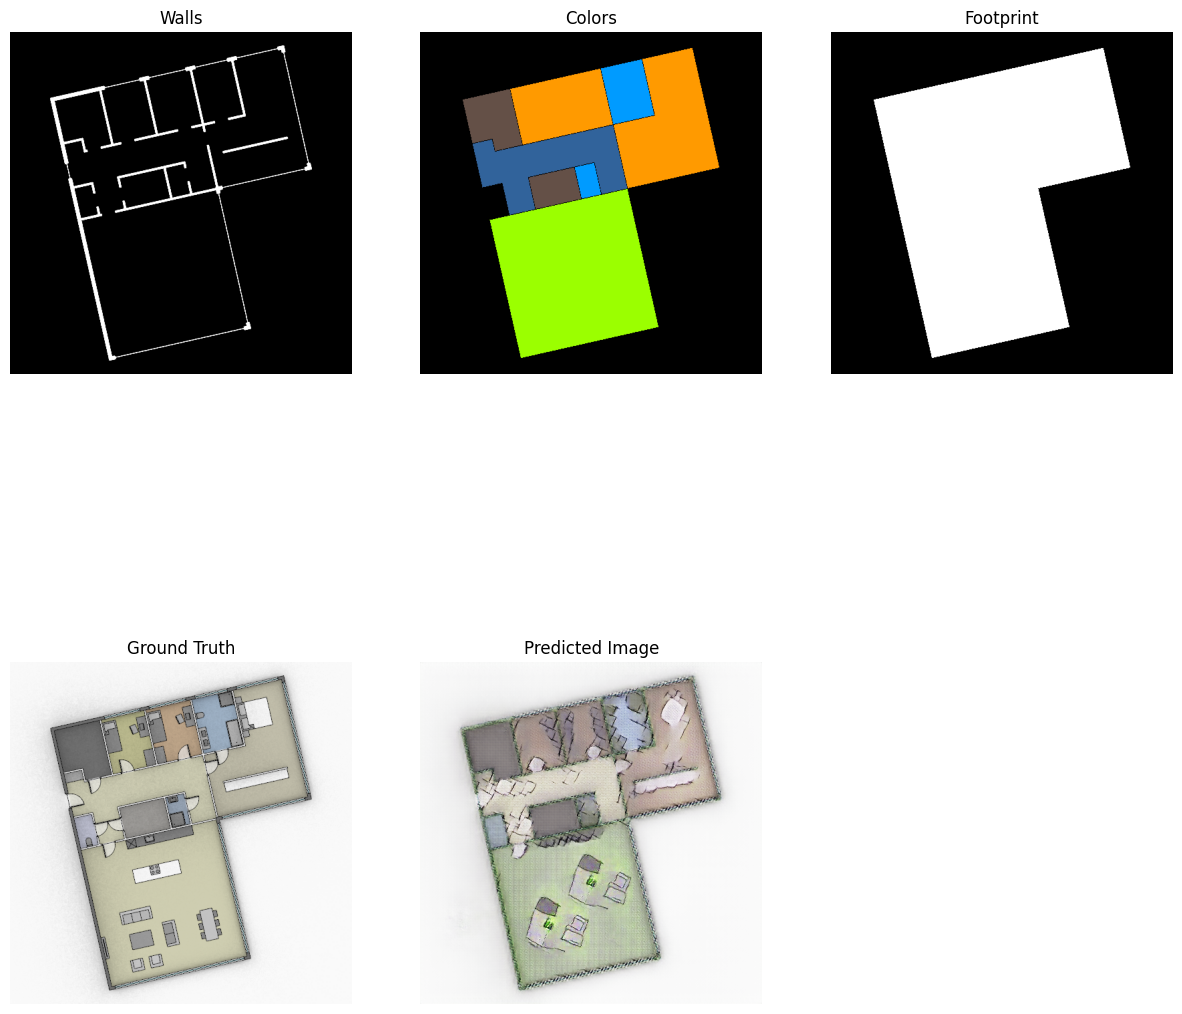

In [35]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)